<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/CNN_Implementation_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

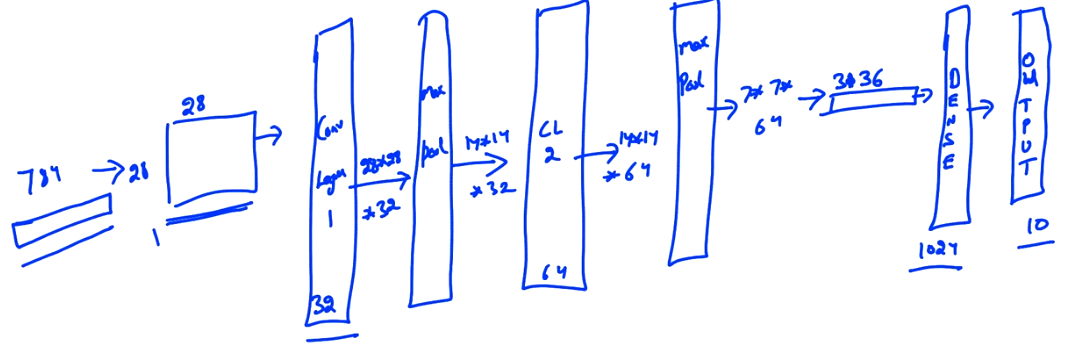

We are using kernels of same depth as given in the previous output.

In [122]:
import tensorflow as tf
from tensorflow import keras

# Loading Data

In [123]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

### One hot vector

In [124]:
# reshaping output data to one hot vector
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

# Various Hyperparameters

In [125]:
input_width = 28
input_height = 28
input_channels = 1
input_pixels = input_width * input_height 

n_conv1 = 32
n_conv2 = 64
stride_conv1 = 1
stride_conv2 = 1
conv1_k = 5
conv2_k = 5
maxPool1_k = 2
maxPool2_k = 2

n_hidden = 1024
n_output = 10

input_size_to_hidden = (input_width//(maxPool1_k * maxPool2_k)) * (input_height//(maxPool1_k * maxPool2_k)) * n_conv2  # last convolution layer depth will be valid
input_size_to_hidden

3136

# Initialising random weight and biases(Parameters)

Initialisation - <   # these slant lines are node connecting edges

visualisation - >

In [126]:
#initialising random values of kernels and FC layers
weights = {
    'wc1' : tf.Variable(tf.random.normal([conv1_k, conv1_k, input_channels, n_conv1])),
    'wc2' : tf.Variable(tf.random.normal([conv2_k, conv2_k, n_conv1, n_conv2])),
    'wh1' : tf.Variable(tf.random.normal([input_size_to_hidden, n_hidden])),
    'wo' : tf.Variable(tf.random.normal([n_hidden, 10]))
}

biases = {
    'bc1' : tf.Variable(tf.random.normal([n_conv1])),
    'bc2' : tf.Variable(tf.random.normal([n_conv2])),
    'bh1' : tf.Variable(tf.random.normal([n_hidden])),
    'bo' : tf.Variable(tf.random.normal([n_output]))
}

# weights['wc1'], biases['bc1']

# over output after adding biases etc.. we take argmax value and convert it into one hot vector.
biases['bc1'].dtype

tf.float32

# Forward Propogation

### Convolution Function

Padding = same means if the stride is 1, it is going to give same output size as input size.

stride = [across_image, height, width, across_channel]  -> total dimension same as x.

similar dimension for ksize and stride in maxpooling.

In [127]:
def conv(x, weights, biases, stride = 1):
  out = tf.nn.conv2d(x, weights, padding = 'SAME', strides = [1, stride, stride, 1])
  out = tf.nn.bias_add(out, biases)     # specialised function to add biases -> take care of dimensions
  out = tf.nn.relu(out)

  return out    

### Maxpooling Function

In [128]:
def maxPooling(x, k = 2):
  return tf.nn.max_pool(x, padding = 'SAME', ksize = [1, k, k, 1], strides = [1, k, k, 1])

### CNN

In [129]:
# above 2 functions can be written directly into below function because using pre-build function in any case.
# * does element wise multiplication of matrix(usually not suitable) but tf.matmul does dot product. + and tf.add is same.

def cnn(x, weights, biases):
  # reshaping the batches properly if not reshaped earlier
  x = tf.reshape(x, [-1,input_height, input_width, input_channels])
  x = tf.cast(x, tf.float32)                    # x should not be of type of 'unic8' etc.. should be changed to proper datatype while downloading i think.
  conv1 = conv(x, weights['wc1'], biases['bc1'])
  conv1_pool = maxPooling(conv1, maxPool1_k)

  conv2 = conv(conv1_pool, weights['wc2'], biases['bc2'])
  conv2_pool = maxPooling(conv2, maxPool2_k)

  hidden_input = tf.reshape(conv2_pool, [-1, input_size_to_hidden])
  hidden_output = tf.nn.relu(tf.matmul(hidden_input,weights['wh1']) + biases['bh1'])

  output = tf.matmul(hidden_output, weights['wo']) + biases['bo']

  return output


# Training our Model
No need to finding cost, optimise via. backpropogation manually. Just train the model with proper batch size.

In [130]:
epochs = 5
batch_size = 256
learning_rate = 0.001

learnable_variables = [weights['wc1'], weights['wc2'], weights['wh1'], weights['wo'], biases['bc1'], biases['bc2'], biases['bh1'], biases['bo']]

total_samples = x_train.shape[0]
steps_per_epoch = total_samples // batch_size      # floor divison

# choosing our optimizer
optimizer = tf.optimizers.Adam(learning_rate)

for epoch in range(epochs):

    total_cost = 0

    for step in range(steps_per_epoch):
        # Get the current batch of data
        start = step * batch_size
        end = start + batch_size
        x_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        # Use tf.GradientTape to record operations
        with tf.GradientTape() as tape:
          
            # Perform forward propagation on the batch of data
            pred = cnn(x_batch, weights, biases)
            # Calculate the loss
            current_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_batch))

        # Use the recorded operations to compute gradients
        grads = tape.gradient(current_loss, learnable_variables)
        
        # Apply gradients to update weights and biases
        optimizer.apply_gradients(zip(grads, learnable_variables))

        total_cost += current_loss
        

    print(f"Epoch: {epoch}, Loss: {total_cost}")

Epoch: 0, Loss: 224502192.0
Epoch: 1, Loss: 39105156.0
Epoch: 2, Loss: 23342380.0
Epoch: 3, Loss: 15846917.0
Epoch: 4, Loss: 11288583.0


In [131]:
# testing by passing the data
x = x_test
y = y_test
pred = cnn(x,weights,biases)

# getting result in desirable format
predictions = tf.argmax(pred,axis = 1)
true_labels = tf.argmax(y,axis = 1)



In [134]:
# Results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(true_labels,predictions))
print('-----------------------------------------------------------------------\n\n')
print(classification_report(true_labels,predictions))

[[ 970    1    0    2    0    1    2    0    2    2]
 [   4 1105    7    0    4    2    1    5    7    0]
 [   4    2 1000    5    3    0    1    9    8    0]
 [   0    0    6  959    2   19    0    6   11    7]
 [   2    0    3    1  957    0    3    7    2    7]
 [   5    1    0    4    1  864    5    1    5    6]
 [   7    1    3    0    6    9  923    1    7    1]
 [   2    5   15    1    7    0    0  985    5    8]
 [   8    1    6    5    3    4    1    2  940    4]
 [   5    3    1    3   19    9    0   15    7  947]]
-----------------------------------------------------------------------


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.99      0.97      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.98      0.95      0.96      1010
           4       0.96      0.97      0.96       982
           5       0.95      0.97      0.96       892
           6    